In [1]:
import torch
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [2]:
img_size = 400

content_image = Image.open("/kaggle/input/content-img/background.jpg")
loader  = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
content_image = loader(content_image).unsqueeze(0)
content_image = content_image.to(torch.float)
print(content_image.shape)

# plt.imshow(content_image[0].view(1, 2, 0))

torch.Size([1, 3, 512, 512])


In [27]:
image_size = (512, 512)

# Generate random noise for each channel
noise_r = torch.randn(*image_size)
noise_g = torch.randn(*image_size)
noise_b = torch.randn(*image_size)

# Combine the noise into a 3-channel image
noise_rgb = torch.stack([noise_r, noise_g, noise_b], dim=0)

# Scale and shift the noise to the range [0, 1]
noise_rgb = (noise_rgb - noise_rgb.min()) / (noise_rgb.max() - noise_rgb.min())
noise_rgb = noise_rgb.unsqueeze(0)
print(noise_rgb.shape)

noise_rgb.is_leaf

torch.Size([1, 3, 512, 512])


True

In [4]:
class NSTVgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.content_layer = [21]
        self.model = vgg19(weights=VGG19_Weights.DEFAULT).features[:29]
        
    def forward(self, x):
        output = list()
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if layer_num in self.content_layer:
                output.append(x)
                
        return output
    
nst_vgg = NSTVgg()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 149MB/s]  


In [6]:
def content_loss(generated_features, content_features):
    _, filters, h, w = generated_features.shape
    
    generated = generated_features.view(_, filters, -1)
    content = content_features.view(_, filters, -1)
    
    return torch.mean(torch.square(torch.sub(content, generated))) / 2

In [42]:
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
print(device)

nst_vgg = NSTVgg().to(device).eval()
content_image = content_image.to(device)
noise_rgb = noise_rgb.to(device).requires_grad_(True)
print(noise_rgb.is_leaf, noise_rgb.requires_grad)


epoch = 100
lr = 0.004

optimizer = torch.optim.Adam([noise_rgb], lr=lr)

for e in range(epoch):
    gen_features = nst_vgg(noise_rgb)
    original_features = nst_vgg(content_image)
    
    loss = content_loss(gen_features[0], original_features[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0:
        print(loss)

cuda
True True
tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0166, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)


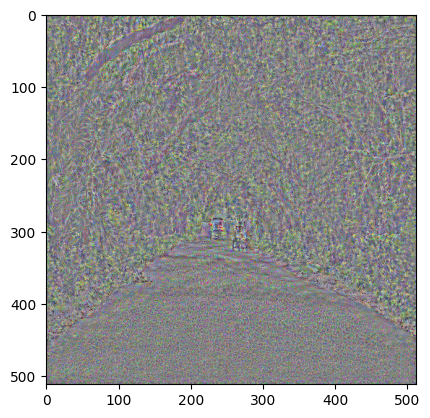

In [43]:
plt.imshow(noise_rgb.permute(0, 2, 3, 1)[0].cpu().detach().numpy())

In [ ]:
vgg_model.features